# **Installing Packages**

In [120]:
!pip install pandasql
!pip install orange3

In [121]:
!pip install scikit-learn-extra

In [122]:
!pip3 install Orange3-Associate

In [123]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [124]:
from sklearn_extra.cluster import KMedoids

# **Load Dataset**

In [125]:
#download dataset
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

In [128]:
#Load dataset
data = pd.read_excel(path)

# **Data Understanding**

In [129]:
data.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [130]:
#data profiling
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(541909, 8)

In [131]:
data.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [132]:
print('Check if we had negative quantity and prices at same register:',
     'No' if data[(data.Quantity<0) & (data.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')

Check if we had negative quantity and prices at same register: No 



In [133]:
print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      data[(data.Quantity<=0) & (data.UnitPrice<=0)].shape[0])

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336


In [134]:
print('\n% Negative Quantity: {:3.2%}'.format(data[(data.Quantity<0)].shape[0]/data.shape[0]))


% Negative Quantity: 1.96%


In [135]:
print('\nAll register with negative quantity has Invoice start with:', 
      data.loc[(data.Quantity<0) & ~(data.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())


All register with negative quantity has Invoice start with: ['C']


In [136]:
print('\nSee an example of negative quantity and others related records:')
display(data[(data.CustomerID==12472) & (data.StockCode==22244)])


See an example of negative quantity and others related records:


InvoiceNo StockCode  ... CustomerID  Country
1973     C536548     22244  ...    12472.0  Germany
9438      537201     22244  ...    12472.0  Germany
121980    546843     22244  ...    12472.0  Germany

[3 rows x 8 columns]

In [137]:
print('Check register with UnitPrice negative:')
display(data[(data.UnitPrice<0)])

Check register with UnitPrice negative:


InvoiceNo StockCode  ... CustomerID         Country
299983   A563186         B  ...        NaN  United Kingdom
299984   A563187         B  ...        NaN  United Kingdom

[2 rows x 8 columns]

In [138]:
print("Sales records with Customer ID and zero in Unit Price:",data[(data.UnitPrice==0)  & ~(data.CustomerID.isnull())].shape[0])
data[(data.UnitPrice==0)  & ~(data.CustomerID.isnull())]

Sales records with Customer ID and zero in Unit Price: 40


InvoiceNo StockCode  ... CustomerID         Country
9302      537197     22841  ...    12647.0         Germany
33576     539263     22580  ...    16560.0  United Kingdom
40089     539722     22423  ...    14911.0            EIRE
47068     540372     22090  ...    13081.0  United Kingdom
47070     540372     22553  ...    13081.0  United Kingdom
56674     541109     22168  ...    15107.0  United Kingdom
86789     543599    84535B  ...    17560.0  United Kingdom
130188    547417     22062  ...    13239.0  United Kingdom
139453    548318     22055  ...    13113.0  United Kingdom
145208    548871     22162  ...    14410.0  United Kingdom
157042    550188     22636  ...    12457.0     Switzerland
187613    553000     47566  ...    17667.0  United Kingdom
198383    554037     22619  ...    12415.0       Australia
279324    561284     22167  ...    16818.0  United Kingdom
282912    561669     22960  ...    12507.0           Spain
285657    561916         M  ...    15581.0  United Kingdom
298054    562973     23157  ...    14911.0            EIRE
314745    564651     23270  ...    14646.0     Netherlands
314746    564651     23268  ...    14646.0     Netherlands
314747    564651     22955  ...    14646.0     Netherlands
314748    564651     21786  ...    14646.0     Netherlands
358655    568158      PADS  ...    16133.0  United Kingdom
361825    568384         M  ...    12748.0  United Kingdom
379913    569716     22778  ...    15804.0  United Kingdom
395529    571035         M  ...    12446.0             RSA
420404    572893     21208  ...    18059.0  United Kingdom
436428    574138     23234  ...    12415.0       Australia
436597    574175     22065  ...    14110.0  United Kingdom
436961    574252         M  ...    12437.0          France
439361    574469     22385  ...    12431.0       Australia
446125    574879     22625  ...    13014.0  United Kingdom
446793    574920     22899  ...    13985.0  United Kingdom
446794    574920     23480  ...    13985.0  United Kingdom
454463    575579     22437  ...    13081.0  United Kingdom
454464    575579     22089  ...    13081.0  United Kingdom
479079    577129     22464  ...    15602.0  United Kingdom
479546    577168         M  ...    12603.0         Germany
480649    577314     23407  ...    12444.0          Norway
485985    577696         M  ...    16406.0  United Kingdom
502122    578841     84826  ...    13256.0  United Kingdom

[40 rows x 8 columns]

# **Data Preparation**

In [139]:
#Remove register without customerID
data = data[~(data.CustomerID.isnull())]

In [140]:
#Remove negative or return transactions
data = data[~(data.Quantity<0)]
data = data[data.UnitPrice>0]

In [141]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


(397884, 8)

In [142]:
desc_df = data.groupby(["StockCode","Description"]).count().reset_index()
display(desc_df.StockCode.value_counts()[desc_df.StockCode.value_counts()>1].reset_index().head())
data[data['StockCode'] == desc_df.StockCode.value_counts()[desc_df.StockCode.value_counts()>1]
      .reset_index()['index'][4]]['Description'].unique()

index  StockCode
0  23196          4
1  23236          4
2  22776          3
3  23240          3
4  23209          3

array(['LUNCH BAG DOILEY PATTERN ', 'LUNCH BAG VINTAGE DOILY ',
       'LUNCH BAG VINTAGE DOILEY '], dtype=object)

In [143]:
unique_desc = data[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from data as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

data = pysqldf(q)

In [144]:
#Change data type
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
data['amount'] = data.Quantity*data.UnitPrice
data.CustomerID = data.CustomerID.astype('int64')

data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  int64         
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   amount       397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 27.3+ MB


(397884, 9)

# **Exploratory Data Analysis**

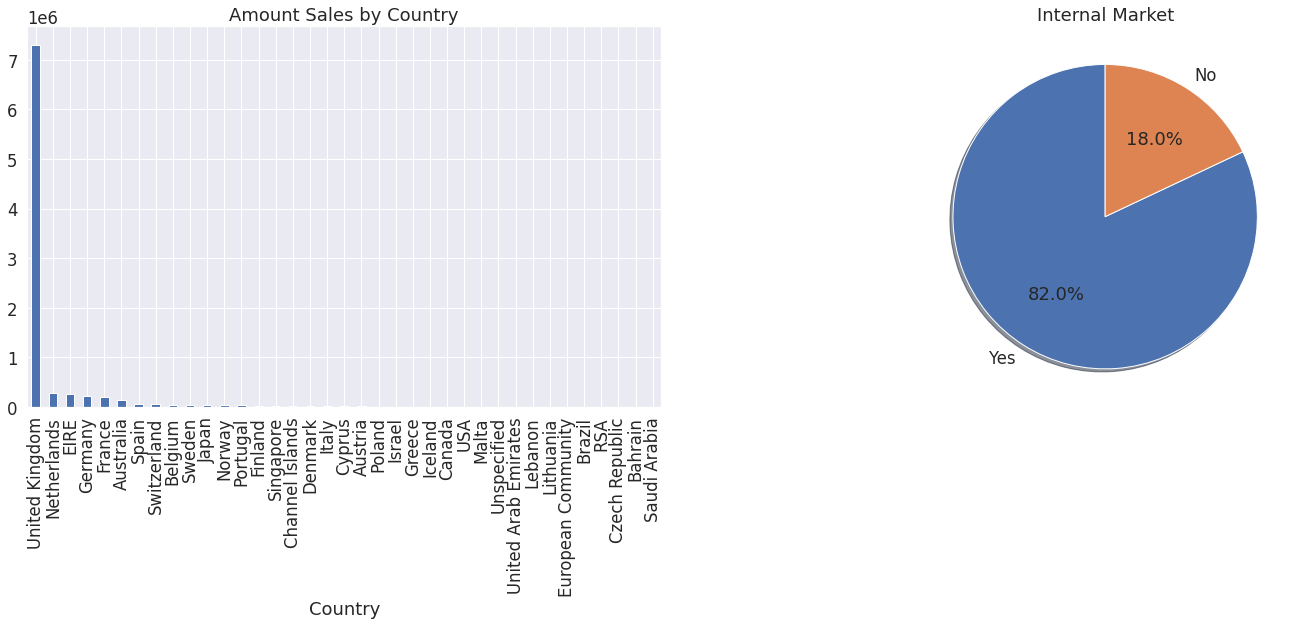

In [145]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = data.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
data['Internal'] = data.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = data.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

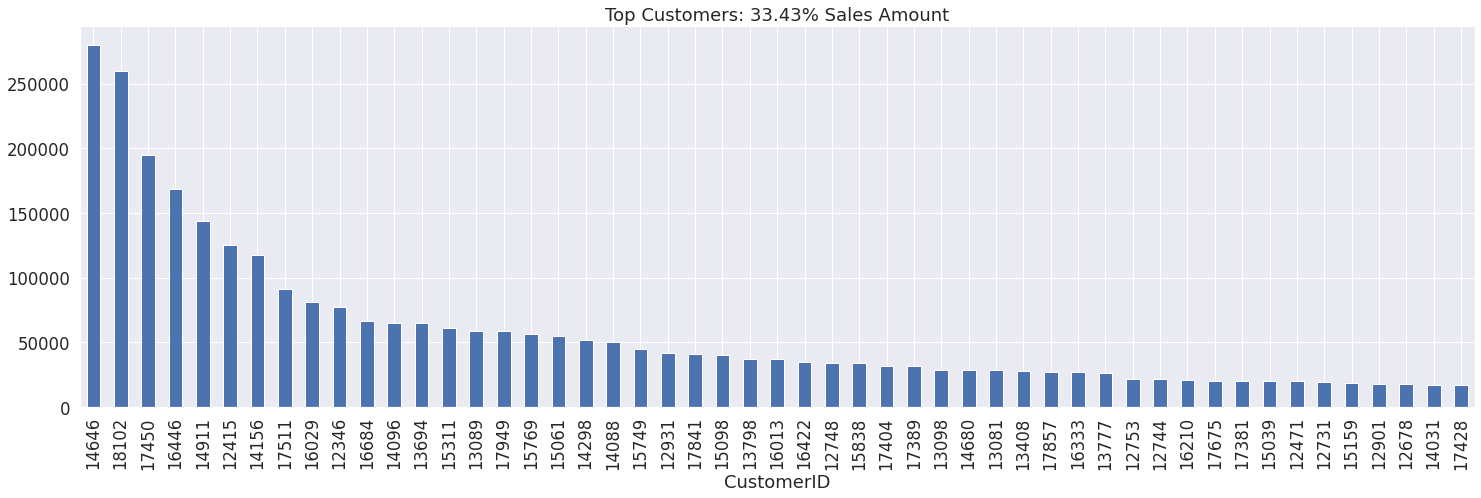

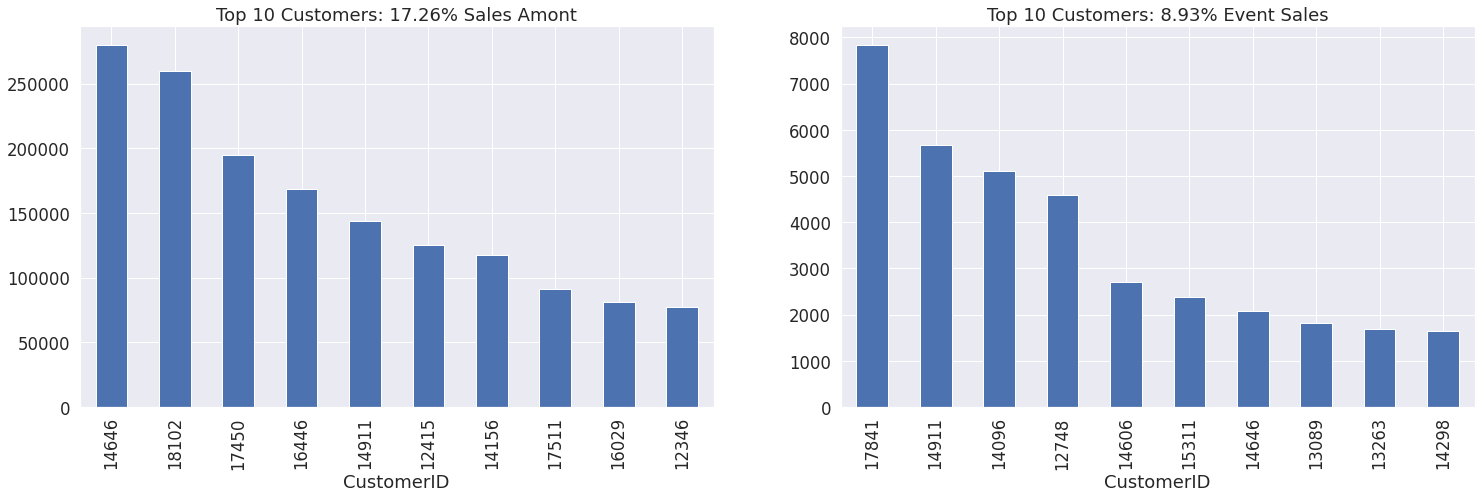

In [146]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((data.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/data.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = data.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((data.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/data.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = data.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((data.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/data.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = data.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

# **Customer Segmentation**

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM, **Recency, Frequency and Monetary Value**, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:


*   **Recency** : Most recent date of purchase in our dataset - Most recent purchase date of the customer
*   **Frequency** : Calculate the total orders for each customer
*   **Monetary** : Calculate the total revenue from each customer



**Recency**

In [147]:
refrence_date = data.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
data['Recency'] = (refrence_date - data.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  data[['CustomerID', 'Recency']].groupby("CustomerID").min().reset_index()
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std  ...      50%       75%      max
CustomerID  4338.0  15300.408022  1721.808492  ...  15299.5  16778.75  18287.0
Recency     4338.0     92.536422   100.014169  ...     51.0    142.00    374.0

[2 rows x 8 columns]

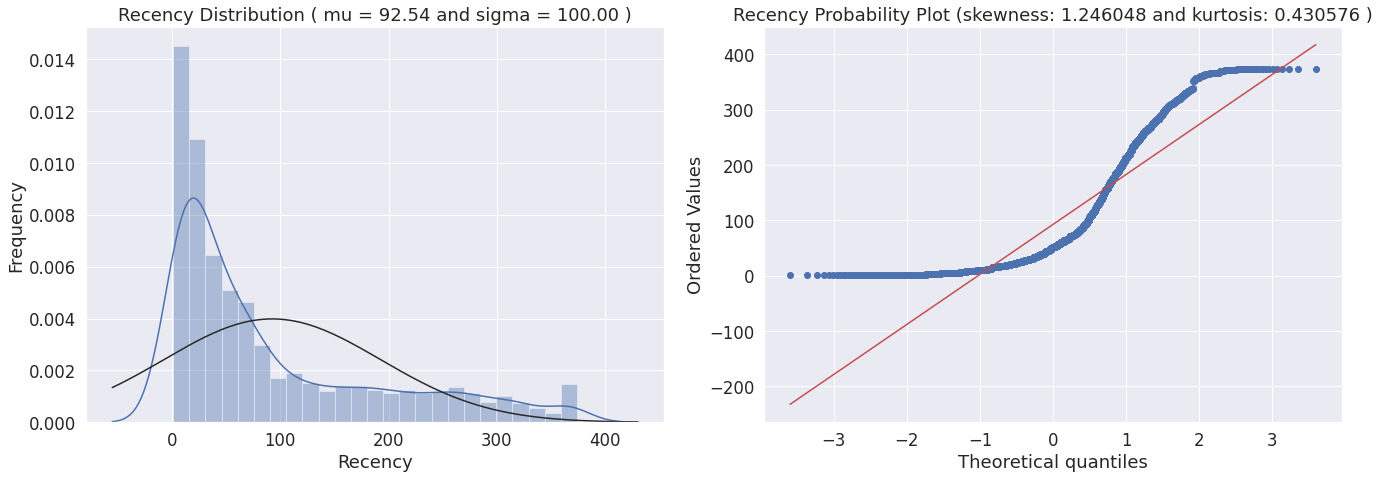

In [148]:
#Plot Recency
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.Recency, 'Recency')

**Frequency**

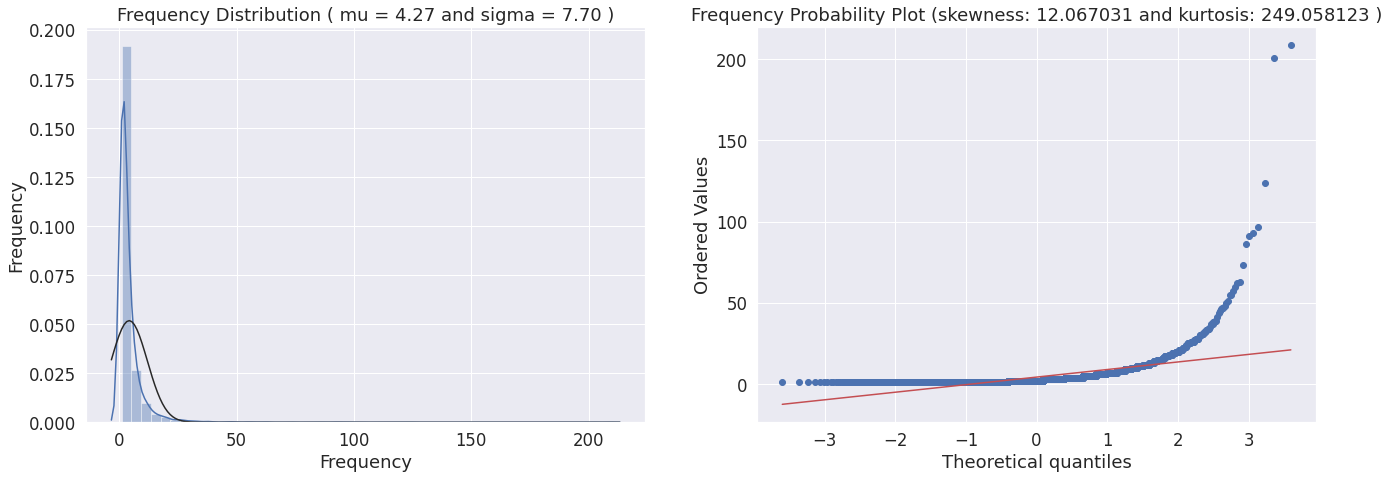

In [149]:
customer_freq = (data[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

**Monetary**

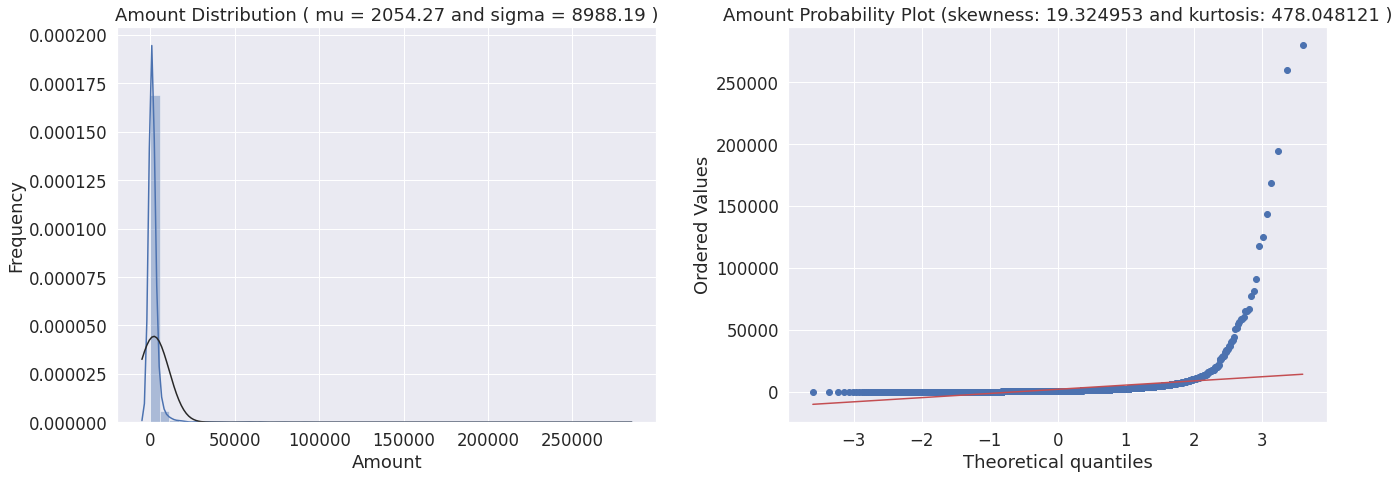

In [150]:
customer_monetary_val = data[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

In [151]:
customer_history_df.describe()

CustomerID      Recency    frequency         amount
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

**Data Standardization**

In [152]:
customer_history_df['recency_log'] = customer_history_df['Recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std  ...       50%       75%       max
amount_log     4338.0 -1.202102e-16  1.000115  ... -0.060942  0.654244  4.721395
recency_log    4338.0 -1.027980e-16  1.000115  ...  0.114707  0.829652  1.505796
frequency_log  4338.0 -2.355833e-16  1.000115  ... -0.279044  0.738267  4.882714

[3 rows x 8 columns]

## **Modeling**

Since our dataset is positive skewed and have heavy-tailed distribution that indicates there are outliers in each variable Recency, Frequency, and Monetary. We try to use K-Medoid Clustering or Partitioning Around Medoids which is insensitive to outlier.

**K-Medoid / Partitioning Around Medoids (PAM) Clustering**

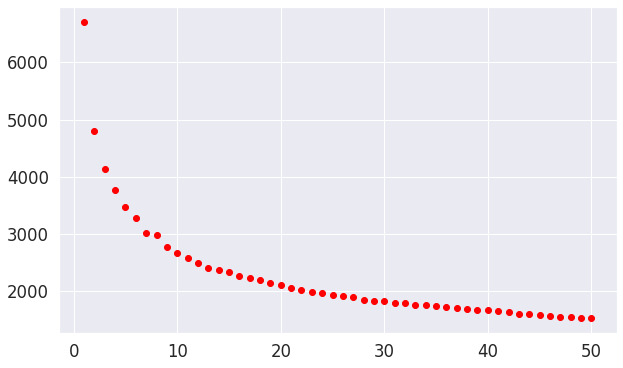

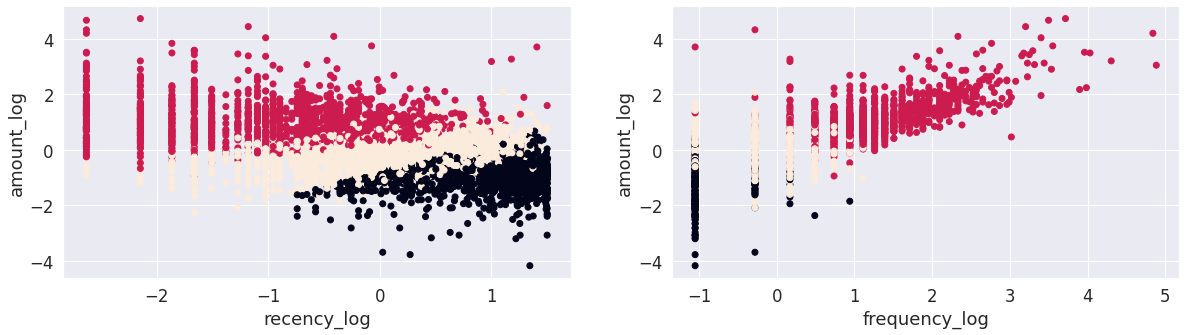

The best K sugest:  3


In [153]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmedoids model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMedoids(n_clusters = k, init='k-medoids++', max_iter=300, random_state = 0)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(10, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmedoids model with the best K.
model = KMedoids(n_clusters=K_best, init='k-medoids++',max_iter=300, random_state=0)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

print('The best K sugest: ',K_best)

**Silhouette Analysis**

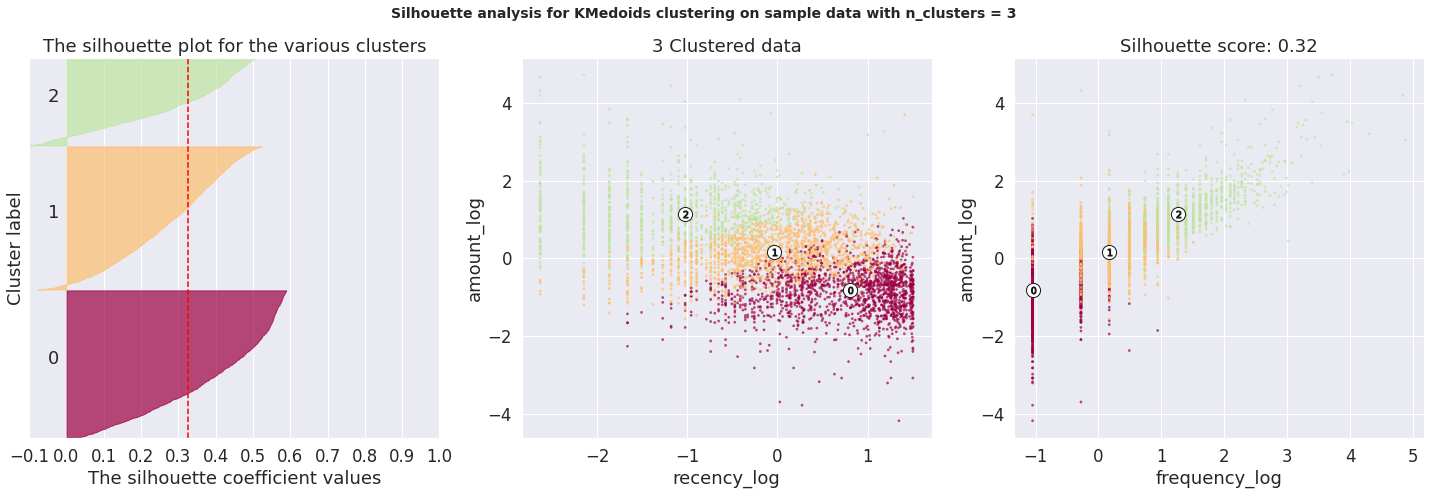

In [154]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMedoids(n_clusters=n_clusters, init='k-medoids++', max_iter=300, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMedoids clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [155]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.32
Centers of each cluster:
    amount  recency  frequency
0   259.01    136.0        1.0
1   895.13     41.0        3.0
2  3023.08     10.0        8.0
--------------------------------------------------


**Conclussions:**

According to Recency, Frequency and Monetary Value of each customers. The customers can be grouped into 3 clusters. 



1.   According to Recency, Frequency and Monetary Value of each customers. The customers can be grouped into 3 clusters. 
2.   The most valuable customers are in the third group, because they are 
shops frequently, low inactivity, and give the highest revenue to the company.


# **Model Evaluation**

In [159]:
#check accuracy
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_scaled, labels)

1.1260554928311424